In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 100

In [2]:
fold = pd.read_csv('../input/5-fold-cross-validation-old-new/5-fold.csv')

In [3]:
fold

,id_code,diagnosis,data,fold_0,fold_1,fold_2,fold_3,fold_4
0,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/40576_left.jpeg,0,old,train,train,train,train,train
1,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/33112_left.jpeg,0,old,train,train,train,train,train
2,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/31961_right.jpeg,0,old,train,train,train,train,train
3,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/2515_left.jpeg,0,old,train,train,train,train,train
4,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/40364_right.jpeg,0,old,train,train,train,train,train
...,...,...,...,...,...,...,...,...
19425,../input/aptos2019-blindness-detection/train_images/ffa47f6a7bf4.png,2,new,train,train,train,validation,train
19426,../input/aptos2019-blindness-detection/train_images/ffc04fed30e6.png,0,new,train,train,train,validation,train
19427,../input/aptos2019-blindness-detection/train_images/ffcf7b45f213.png,2,new,train,train,validation,train,train
19428,../input/aptos2019-blindness-detection/train_images/ffd97f8cd5aa.png,0,new,validation,train,train,train,train


In [4]:
fold1_train = fold[fold['fold_0'] == 'train'][['id_code','diagnosis']]
fold1_valid = fold[fold['fold_0'] == 'validation'][['id_code','diagnosis']]
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [5]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

In [6]:
train['id_code'] = train['id_code'].apply(lambda x: x + '.png')

In [7]:
test['id_code'] = test['id_code'].apply(lambda x: x + '.png')

In [8]:
fold1_train.shape, fold1_valid.shape

((18697, 2), (733, 2))

In [9]:
fold1_train

,id_code,diagnosis
0,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/40576_left.jpeg,0
1,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/33112_left.jpeg,0
2,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/31961_right.jpeg,0
3,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/2515_left.jpeg,0
4,../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/40364_right.jpeg,0
...,...,...
19424,../input/aptos2019-blindness-detection/train_images/ff8a0b45c789.png,4
19425,../input/aptos2019-blindness-detection/train_images/ffa47f6a7bf4.png,2
19426,../input/aptos2019-blindness-detection/train_images/ffc04fed30e6.png,0
19427,../input/aptos2019-blindness-detection/train_images/ffcf7b45f213.png,2


In [10]:
fold1_valid

,id_code,diagnosis
15770,../input/aptos2019-blindness-detection/train_images/0024cdab0c1e.png,1
15772,../input/aptos2019-blindness-detection/train_images/005b95c28852.png,0
15774,../input/aptos2019-blindness-detection/train_images/0097f532ac9f.png,0
15775,../input/aptos2019-blindness-detection/train_images/00a8624548a9.png,2
15781,../input/aptos2019-blindness-detection/train_images/0104b032c141.png,3
...,...,...
19400,../input/aptos2019-blindness-detection/train_images/fe06dad6851c.png,0
19405,../input/aptos2019-blindness-detection/train_images/fe3b0e50be78.png,0
19419,../input/aptos2019-blindness-detection/train_images/ff4cd992667b.png,0
19423,../input/aptos2019-blindness-detection/train_images/ff77e8e5b5f3.png,2


In [11]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = fold1_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

metric_list = ["accuracy"]

In [12]:
fold1_train['diagnosis'] = fold1_train['diagnosis'].astype(str)
fold1_valid['diagnosis'] = fold1_valid['diagnosis'].astype(str)

In [13]:
datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

train_generator=datagen.flow_from_dataframe(
                        dataframe=fold1_train,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="categorical",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH))

valid_generator=datagen.flow_from_dataframe(
                        dataframe=fold1_valid,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="categorical",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH))

test_generator=datagen.flow_from_dataframe(  
                       dataframe=test,
                       directory='../input/aptos2019-blindness-detection/test_images',
                       x_col="id_code",
                       batch_size=1,
                       class_mode=None,
                       shuffle=False,
                       target_size=(HEIGHT, WIDTH))

Found 18683 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [14]:
def create_model(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB0(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(5, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [15]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL))

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

In [16]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit(train_generator,
                                     validation_data=valid_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=3,
                                     verbose=1).history

Epoch 1/3
2335/2335 [==============================] - 1152s 490ms/step - loss: 1.3810 - accuracy: 0.3965 - val_loss: 1.3066 - val_accuracy: 0.4959
Epoch 2/3
2335/2335 [==============================] - 963s 412ms/step - loss: 1.3448 - accuracy: 0.4091 - val_loss: 1.3360 - val_accuracy: 0.4890
Epoch 3/3
2335/2335 [==============================] - 933s 400ms/step - loss: 1.3434 - accuracy: 0.4058 - val_loss: 1.3378 - val_accuracy: 0.4904


In [17]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [18]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=15,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/15
2335/2335 [==============================] - 994s 422ms/step - loss: 0.5148 - accuracy: 0.4420 - val_loss: 0.4110 - val_accuracy: 0.5069
Epoch 2/15
2335/2335 [==============================] - 981s 420ms/step - loss: 0.3722 - accuracy: 0.5388 - val_loss: 0.4192 - val_accuracy: 0.5179
Epoch 3/15
2335/2335 [==============================] - 988s 423ms/step - loss: 0.3475 - accuracy: 0.5791 - val_loss: 0.3931 - val_accuracy: 0.5783
Epoch 4/15
2335/2335 [==============================] - 975s 418ms/step - loss: 0.3345 - accuracy: 0.6025 - val_loss: 0.4129 - val_accuracy: 0.4821
Epoch 5/15
2335/2335 [==============================] - 979s 419ms/step - loss: 0.3268 - accuracy: 0.6094 - val_loss: 0.4586 - val_accuracy: 0.3723
Epoch 6/15
2335/2335 [==============================] - 981s 420ms/step - loss: 0.3193 - accuracy: 0.6189 - val_loss: 0.3424 - val_accuracy: 0.6786
Epoch 7/15
2335/2335 [==============================] - 981s 420ms/step - loss: 0.3099 - accuracy: 0.6326 - val_

In [19]:
model.save('effb0-f0.h5')

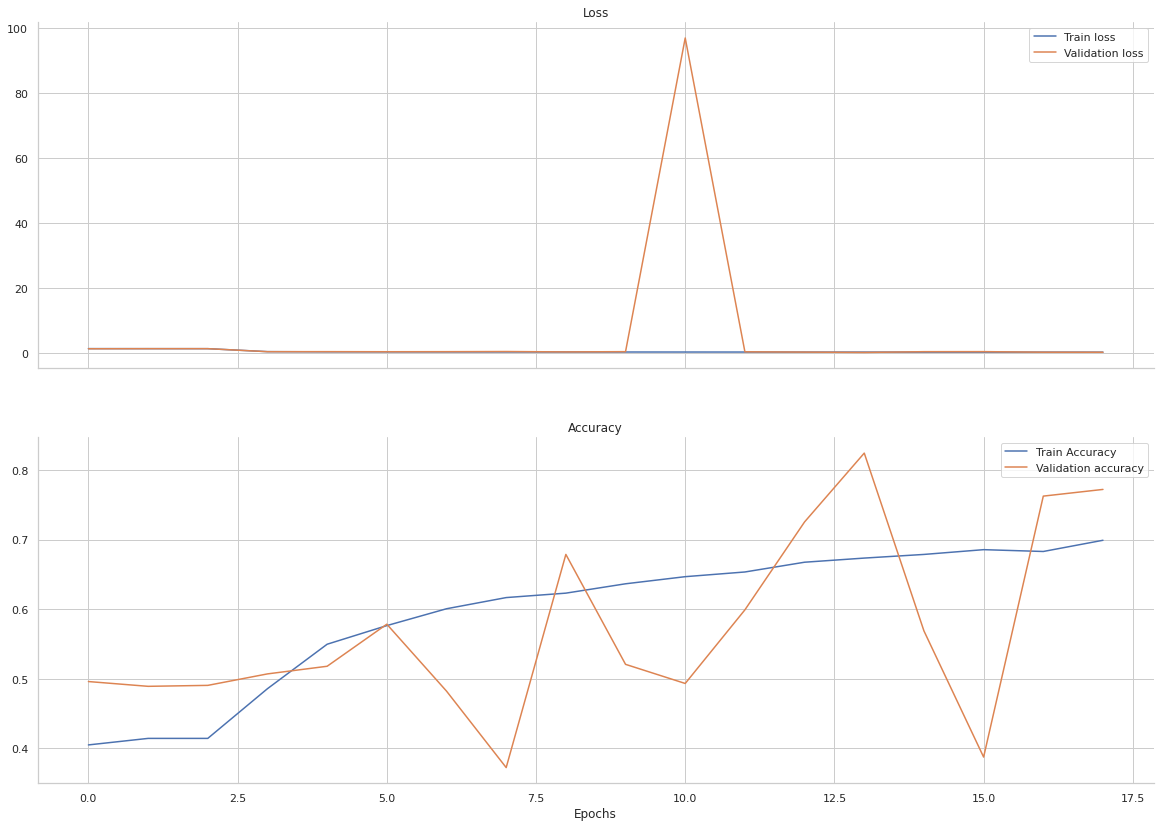

In [20]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [21]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


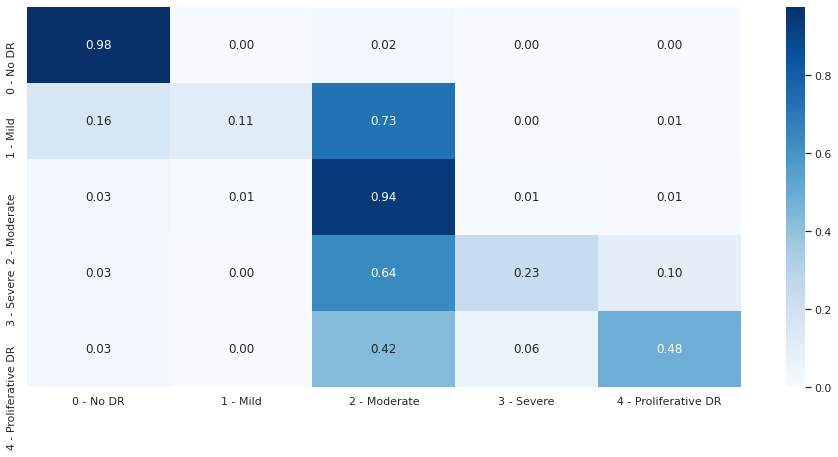

In [22]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [23]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.861


In [24]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,4
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,2
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,0


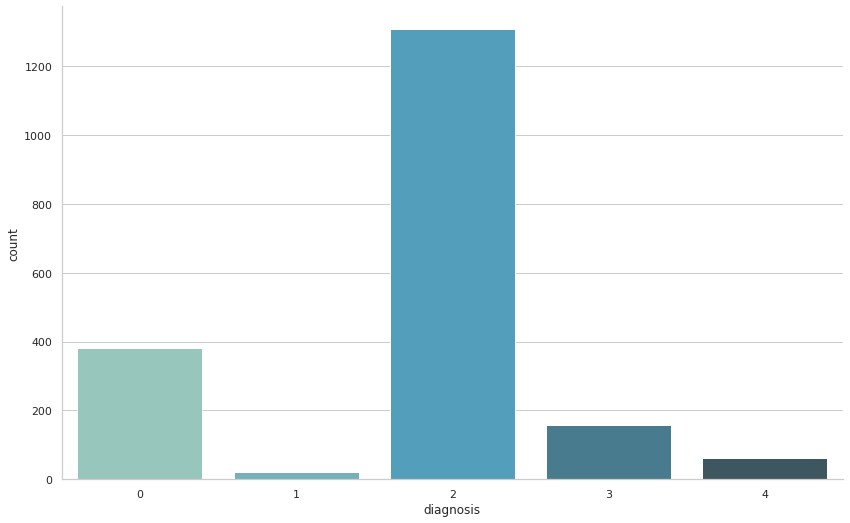

In [25]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()